# N body simulation

### Background theory

From Newton's first law $F_{net}=\Sigma_ima$ we find the acceleration of particle $i$ at position $r_i$ and time t to be

$\frac{d^2 \vec{r_i}}{dt^2} = \Sigma_{j\neq i} \frac{G m_j}{\vert \vec{r_i} - \vec{r_j} \vert ^3} (\vec{r_i}-\vec{r_j})$

This equation is plagued by extremely small  and large numbers e.g. ($G \approx 6.67 \times 10^{-11}$), which do not work well with the limmited precision of floating point numbers. So strive to put equaiton into dimensionless form, such that the constants take on smaller values.

$\vec{r}' \equiv \frac{\vec{r}}{L}$, $m' \equiv \frac{m}{M}$, and $t'\equiv \frac{t}{\tau}$;

where $L$ is the charactersitic length scale (e.g 1AU for solar system simulations, 10lpc for galaxy simulations), $M$ is the characteristic mass scale (e.g. $M_{sun}$ for solar system), and $\tau$ is the time scale (units of time, e.g. 1 million years for galaxy formation simulation). The one free parameter is $\tau$ which we can choose to be such that it cancels the other parameters with dimensions in the problem. We find a convenient value of the parameter by plugging these values into the DE and setting the dimesnionless group equal to 1.

$\frac{d^2 (\vec{r_i}' L)}{d(\tau \space t')^2} = \Sigma_{j\neq i} \frac{G \space (m_j' M)}{\vert \vec{r_i}' L - \vec{r_j}' L \vert ^3} (\vec{r_i}' L-\vec{r_j}' L)$
$\implies$
$\frac{L^3}{G M \tau ^3}\frac{d^2 (\vec{r_i}')}{d(\space t')^2} = \Sigma_{j\neq i} \frac{m_j'}{\vert \vec{r_i}' - \vec{r_j}'\vert ^3} (\vec{r_i}' -\vec{r_j}')$

Identifying the dimensionless group $\frac{L^3}{G M \tau ^2}$, and setting equal to one we get $\tau = \sqrt{\frac{L^3}{G M}}$. Using this time scale, and making the substitutions 

$\vec{r} \leftarrow \frac{\vec{r}}{L}$, $m \leftarrow \frac{m}{M}$, and $t \leftarrow t \sqrt{\frac{L^3}{G M}}$, we obtain the dimensionless form of the equation 

$$\frac{d^2 \vec{r_i}}{dt^2} = \Sigma_{j\neq i} \frac{m_j}{\vert \vec{r_i} - \vec{r_j} \vert ^3} (\vec{r_i}-\vec{r_j})$$

where the mass and length scales are to be chosen appropriately for a given problem, such that the lengths and masses are of order 1. Once the simulation is run, we can find the actual lengths, times, and masses at the end by plugging values back into the defining equations of the dimensionless variables. This reduces numerical errors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import G

from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

In [16]:
def find_acceleration(position, mass):
    """
    Get acceleration of each particle in a N particle system at a given time
    
        Args:
            position (array): Nx3 array of particle positions
            mass (array): Nx1 array of particle masses
        
        Returns:
            a (array): Nx3 array of acceleration vectors  
    """
    
    N = position.shape[0]
    
    # Get pairwise displacement from between each particle
    displacement = position - position.reshape(N, 1, 3)
    
    # Remove displacement of particle with itself
    zero = np.all((displacement==0), axis=2)
    displacement[zero] = np.nan
    
    # Inverse distance cubed 
    inv_dist_cubed = (np.sum(displacement**2, axis=2) ** -1.5).reshape(N, N, 1)
    
    # Acceleration vectors for each component
    acc_vec = displacement * inv_dist_cubed * mass.reshape(1,N,1)
    
    # Resultant acceleration vectors
    acceleration = np.nansum(acc_vec, axis=1)
    
    return acceleration

def integrator(initial_position, initial_velocity, mass, time):
    """
    Calculates the position, velocity, and acceleration of each particle at all points after t=0 
    to a given time
    
        Args:
            initial_position (array): Nx3 array of particle positions at t=0
            initial_velcity (array): Nx3 array of particle velocities at t=0
            mass (array): Nx1 array of particle masses
            time (float): Time (in dimensionless form) to run simulation for
        Returns:
            position (array): Nx3 array of particle positions at the end of simulation
    TODO: Implement Runge-Kutta, instead of Eulers method. Could also use Scipy.integrate instead
    """
    # Time step
    dt = 0.001
    
    # Number of time steps
    N = int(time / dt)
    
    # Array containing path traced by particles
    n = initial_position.shape[0]                 # Number of particles in simulation
    dimensions = 3                                # Number of spatial dimesnions (x,y,z)
    positions = np.zeros((N, n, dimensions))
    
    # Initialising particle position and velocity
    position = initial_position
    velocity = initial_velocity
    
    for i in range(N):
        # Update positions, velocities, and acclerations using kinematic formulas for small time dt
        acceleration = find_acceleration(position, mass)
        velocity += acceleration * dt
        position += velocity * dt
        
        # Store in a array for plotting
        positions[i] += position
    
    return positions


def animate(positions):
    """
    Create plot of paths traced by particles in 3D space
    """
    # Number of particles in simulation
    N = positions.shape[1]
    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    for i in range(N):
        particle_i = positions[:, i]
        plt.plot(particle_i[:,0], particle_i[:,1], particle_i[:,2])
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Trajectory of N body system')
    
    return

def animate(positions):
    """
    Create plot of paths traced by particles in 3D space
    TODO: Make into animation rather than static image, and make it look better
    """
    # Number of particles in simulation
    N = positions.shape[1]
    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    for i in range(N):
        particle_i = positions[:, i]
        plt.plot(particle_i[:,0], particle_i[:,1], particle_i[:,2])
    
    return

def get_particle_i(positions, i):
    """
    Returns ith particles positions, 0 <= i < N
    """
    return positions[:, i, :]

def get_particle_coordinate(positions, i, axis):
    """
    Returns ith particles coordinates on given axis
    
    Args:
        positions (array): nxNx3 array of particle positions over time
        i (int): The particle you want to choose, 0 <= i < N
        axis (string): "x", "y", or "z"
    """
    axes = {"x": 0, "y": 1, "z": 2}
    axes_index = axes[axis]
    
    if axis not in axes.keys():
        raise("""Must input "x", "y", or "z" as axis""")
    
    return positions[:, i, axes_index]


### Planetary orbits

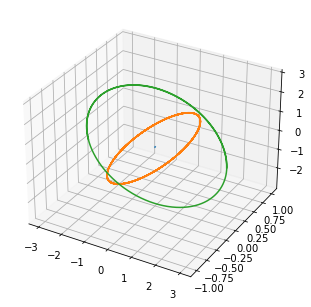

In [17]:
# Sun Earth type of system
m_1 = 1
m_2 = 1e-4
m_3 = 2e-4

# Star
p1_start = np.array([0.0, 0, 0])
v1_start = np.array([0.0, 0, 0])

# Planet 1
p2_start = np.array([1.0, 0, 0])
v2_start = np.array([0.0, 1, 0])

# Planet 2
p3_start = np.array([3.0, 0, 0])
v3_start = np.array([0.0, 0, 1/np.sqrt(3)])


init_pos = np.array([p1_start, p2_start, p3_start])
init_v = np.array([v1_start, v2_start, v3_start])
mass = np.array([m_1, m_2, m_3])

positions = integrator(init_pos, init_v, mass, 50)
animate(positions)